# TME 2: IA Explicable

LE LORIER Yann

NGUYEN Hoang-Son 

### 1. Installation

In [2]:
def warn(*args, **kwargs): # pour éliminer les warnings de sklearn
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=UserWarning)

In [118]:
import dice_ml

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 2. Données

In [120]:
def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    if labels is not None:
        labels = labels.reshape(-1)
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

In [121]:
def halfmoon(n_samples, epsilon):
    pts = np.linspace(0,180, n_samples//2)* np.pi / 180
    haut = np.hstack((np.cos(pts).reshape((-1,1)), np.sin(pts).reshape((-1,1))))
    bas = np.hstack((1-np.cos(pts).reshape((-1,1)), 0.5-np.sin(pts).reshape((-1,1))))
    data = np.vstack((haut,bas))
    data[:,0]+=np.random.normal(0,epsilon,n_samples)
    data[:,1]+=np.random.normal(0,epsilon,n_samples)
    y = np.zeros(n_samples)
    y[n_samples//2:]=1
    return data, y

In [122]:
hm = halfmoon(1000, 0.1)

In [123]:
hm_df = pd.DataFrame(hm[0], columns=['x','y'])
hm_df['target'] = hm[1]

In [125]:
hm_df.columns

Index(['x', 'y', 'target'], dtype='object')

In [126]:
hm_dice = dice_ml.Data(dataframe=hm_df, continuous_features=['x','y'], outcome_name='target')

### 3. Classifieurs

#### pyTorch

In [127]:
class RegLog(torch.nn.Module):
    def __init__(self, dim_in, dim_out, lr = 0.01):
        super().__init__()
        self.epoch = 100
        self.lr = lr
        self.linear = torch.nn.Linear(dim_in, dim_out)
        self.loss = torch.nn.BCELoss()
        self.optim = torch.optim.Adam(self.linear.parameters(), lr = self.lr)
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        return self.sig(x)
    
    def fit(self, x, y):
        for i in range(self.epoch):
            y_pred = self.forward(x)
            loss = self.loss(y_pred, y)
            loss.backward()
            self.optim.step()
            self.optim.zero_grad()

    def predict(self, x, thresh = 0.5):
        y_pred = self.forward(x)
        y_pred[y_pred>=thresh]=1
        y_pred[y_pred<thresh]=0
        return y_pred

In [128]:
x, y = hm
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [129]:
dim_in = x_train.shape[1]
dim_out = 1
tensor_x_train = torch.from_numpy(x_train)
tensor_x_train = torch.tensor(tensor_x_train, dtype=torch.float32)
tensor_x_test = torch.from_numpy(x_test)
tensor_x_test = torch.tensor(tensor_x_test, dtype=torch.float32)


tensor_y_train = torch.from_numpy(y_train)
tensor_y_train = tensor_y_train.view(-1, 1)
tensor_y_train = torch.tensor(tensor_y_train, dtype=torch.float32)

tensor_y_test = torch.from_numpy(y_test)
tensor_y_test = tensor_y_test.view(-1, 1)
tensor_y_test = torch.tensor(tensor_y_test, dtype=torch.float32)

In [130]:
clf_torch = RegLog(dim_in=dim_in, dim_out=dim_out)
clf_torch.fit(tensor_x_train, tensor_y_train)
y_test_pred = clf_torch.predict(tensor_x_test)
accuracy_score(tensor_y_test, y_pred=y_test_pred.detach().numpy())

0.745

In [131]:
model_torch = dice_ml.Model(model=clf_torch, backend="PYT")

---
#### sklearn

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [133]:
X_train, X_test, y_train, y_test = train_test_split(hm_df[['x', 'y']], hm_df['target'], test_size=0.2, shuffle = True)

In [134]:
clf = SVC(probability=True)

In [135]:
clf.fit(X_train, y_train)

SVC(probability=True)

In [136]:
model = dice_ml.Model(model=clf, backend="sklearn")

### 4. Exemples contrefactuels

In [137]:
explainer = dice_ml.Dice(hm_dice, model, method='random')
explainer_torch = dice_ml.Dice(hm_dice, model_torch)
# random, genetic or kdtree

In [138]:
hm_df.head()

,x,y,target
0,0.898849,-0.027308,0.0
1,0.848630,0.062962,0.0
2,1.143834,-0.021721,0.0
3,1.018896,0.022348,0.0
4,1.178119,0.010914,0.0


In [139]:
query_instances = hm_df.drop(columns="target")[0:1]
counterfactuals = explainer.generate_counterfactuals(
    query_instances=query_instances,
    total_CFs=50,
    desired_class='opposite',
    proximity_weight=0.5,
    diversity_weight=1.0,
    features_to_vary='all',
    permitted_range=None,
    posthoc_sparsity_param=0.1
)

counterfacuals_torch = explainer.generate_counterfactuals(\
    query_instances=query_instances,
    total_CFs=50,\
    desired_class ="opposite",\
    proximity_weight=0.5,\
    diversity_weight=1.0,\
    features_to_vary="all",\
    permitted_range=None,\
    posthoc_sparsity_param=0.1
    )


100%|██████████| 1/1 [00:35<00:00, 35.59s/it]


### 5. Visualisation

#### sk-learn

In [140]:
counterfactuals.visualize_as_dataframe()

Query instance (original outcome : 0)


,x,y,target
0,0.898849,-0.027308,0



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.377676,-0.027308,1
1,0.602575,-0.027308,1
2,2.016368,-0.027308,1
3,0.898849,-0.159132,1
4,0.898849,-0.438006,1
5,2.193649,0.510525,1
6,1.818428,-0.027308,1
7,0.267849,0.528493,1
8,0.407186,-0.027308,1
9,1.574540,-0.027308,1


In [141]:
df_cfs = counterfactuals.cf_examples_list[0].final_cfs_df
df_cfs[df_cfs['target'] == 0]

,x,y,target


#### pyTorch

In [142]:
counterfacuals_torch.visualize_as_dataframe()

Query instance (original outcome : 0)


,x,y,target
0,0.898849,-0.027308,0



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.898849,-0.723639,1
1,1.671566,-0.027308,1
2,0.898849,-0.389292,1
3,-0.690626,-0.694555,1
4,0.898849,-0.409776,1
5,0.126481,-0.027308,1
6,1.631515,-0.027308,1
7,0.434284,-0.027308,1
8,0.064132,0.345512,1
9,-0.417819,-0.611538,1


In [143]:
df_cfs_torch = counterfacuals_torch.cf_examples_list[0].final_cfs_df
df_cfs_torch[df_cfs_torch['target'] == 0]

,x,y,target


Nous remarquons qu'avec sklearn, nous pourrions avoir la possibilité d'avoir des exemples contrefactuels mal générés (selon le seed). Avec pyTorch, cette probabilité d'avoir des exemples contrefactuels est très faible.

### 6. Visualisations et expérimentations

In [144]:
from sklearn.inspection import DecisionBoundaryDisplay
def visualisation_2D(data, y, clf, x, cfs) -> None:
    """
    Params:
      data: données
      y   : labels des données
      clf : un classifieur
      x   : un point de départ dont point cicle nous voulons chercher
      cfs : contrefactuels générés
    """
    disp = DecisionBoundaryDisplay.from_estimator(
      clf, data, response_method="predict",
      xlabel="X", ylabel="Y",
      alpha=0.5)
    disp.ax_.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y, edgecolor="k",alpha=0.2)
    disp.ax_.scatter(x.iloc[0][0], x.iloc[0][1], color="red", label="point choisi")
    disp.ax_.scatter(cfs[:, 0], cfs[:, 1], color="green", label="CF générés")
    
    plt.legend()
    plt.show()

In [37]:
cfs = counterfactuals.cf_examples_list[0].final_cfs_df.drop(columns="target")
cfs_np = cfs.to_numpy()

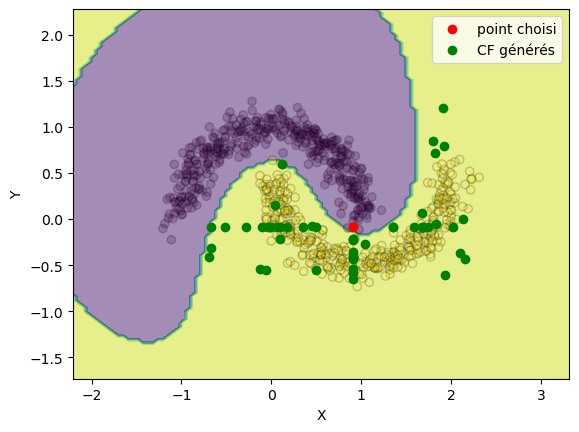

In [38]:
visualisation_2D(X_train, y_train, clf, query_instances, cfs_np)

Puisque nous allons générer des données contrefactuelles plusieurs fois, nous pouvons alors implémenter une fonction pour faire varier les arguments plus facilement: `gen_cfs`.

In [39]:
def gen_cfs(explainer, query_instances, target=None, ftv=None, n_counterfactuals=4):
    """
    Cette fonction prépare les données pour les passer à la fonction de visualisation `visualisation_2D`
    
    explainer: l'instance de Dice pour expliquer.
    query_instances: le X particulier à faire varier
    features_to_vary: les attributs de X à faire varier pour obtenir des contrefactuels différents
    """
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=query_instances,
        total_CFs=n_counterfactuals,
        desired_class='opposite',
        proximity_weight=0.5,
        diversity_weight=1.0,
        features_to_vary='all' if ftv is None else ftv,
        permitted_range=None,
        posthoc_sparsity_param=0.1
    )
    cfs = counterfactuals.cf_examples_list[0].final_cfs_df.drop(columns=target)
    cfs_np = cfs.to_numpy()
    
    return cfs, cfs_np

#### 6.1 Variations dans l'appel à la fonction

100%|██████████| 1/1 [00:00<00:00, 26.57it/s]


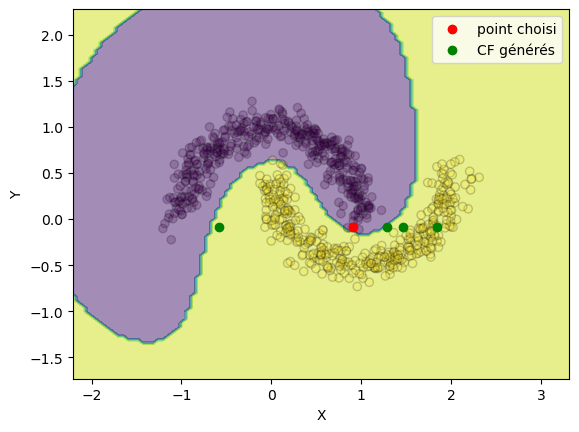

In [40]:
cfs, cfs2_np = gen_cfs(explainer, query_instances, ftv=['x'], target='target')
visualisation_2D(X_train, y_train, clf, query_instances, cfs2_np)

100%|██████████| 1/1 [00:00<00:00, 25.27it/s]


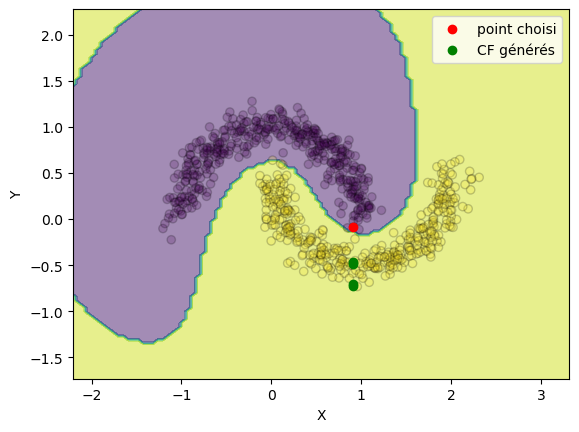

In [41]:
cfs3, cfs3_np = gen_cfs(explainer, query_instances, ftv=['y'], target='target')
visualisation_2D(X_train, y_train, clf, query_instances, cfs3_np)

#### 6.2 Variations dans le point choisi

In [42]:
query_instances = hm_df.drop(columns="target")[300:301]

100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


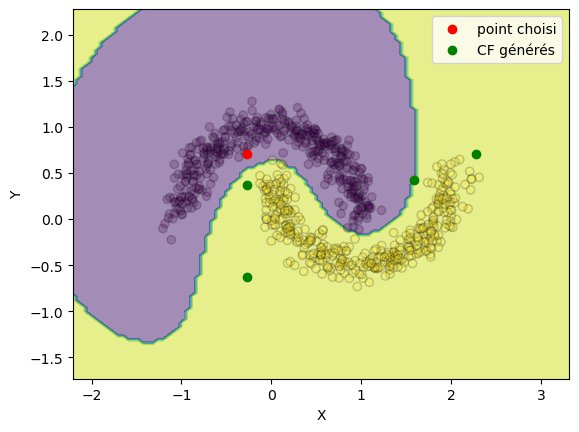

In [43]:
cfs4, cfs4_np = gen_cfs(explainer, query_instances, target='target')
visualisation_2D(X_train, y_train, clf, query_instances, cfs4_np)

100%|██████████| 1/1 [00:00<00:00, 25.72it/s]


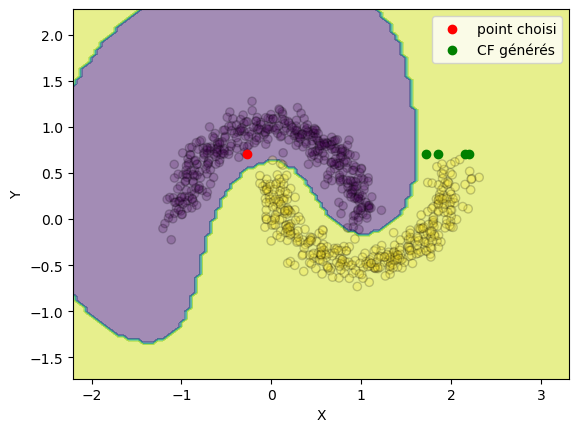

In [44]:
cfs5, cfs5_np = gen_cfs(explainer, query_instances, ftv=['x'], target='target')
visualisation_2D(X_train, y_train, clf, query_instances, cfs5_np)

#### 6.3 Validité des exemples contrefactuels

Nou voulons calculer la proportion des exemples contre-factuels qui sont bien générés, qui appartiennent à des classes autre que la classe de l'exemple nous voulons expliquer.

$$
\text{validité}(e, x) = \frac{\sum_{i=1}^{k} C(f(e_i), f(x))}{k}
$$

Où $ \forall i \in \{1,\dots,k\} \; C(f(e_i), f(x))=1$ si $e_i$ est prédit comme une classe différente que celle de $x$.
$f(e_i)$ est la probabilité pour que $e_i$ appartienne à la classe de $x$.
Si:
- $f(e_i) > t > 0.5$, $C(f(e_i), f(x))=0$
- proportionnelle à $f(e) - f(x)$ si $f(e) \in [0.5,t]$
- Nous mettons une pénalité si $f(e) < 0.5$


In [1]:
def compute_loss_validity(cl_points, query_instances, clf, thresh = 0.5):
    """
        Calculer la loss entre f(e) et f(x)
    """
    # Nous inversons les calculs car nous utilisons la prediction d'être prédit comme la classe de x
    loss = 0
    classe_x = clf.predict(query_instances)[0]
    pred_dans_classe_x = clf.predict_proba(cl_points)[:, int(classe_x)] # nous recupérons la probabilité d'être prédit comme la classe de x
    ### f(e) > t >= 0.5
    tmp = np.where(pred_dans_classe_x < (1-thresh))[0] # [0] car cela retourne une tuple ..
    loss += 0*len(tmp) # C = 0
    ### 0.5 < f(e) < thresh
    tmp = np.where((pred_dans_classe_x < 0.5) & (pred_dans_classe_x > (1-thresh)))
    pred_dans_classe_x = pred_dans_classe_x[tmp]
    f_x = np.max(clf.predict_proba(query_instances))
    loss += (f_x - pred_dans_classe_x).sum()
    ### f(e) < 0.5
    tmp = np.where(pred_dans_classe_x > 0.5)[0]
    loss += 1*len(tmp) # mettre une pénalité si les exemples sont prédit comme la classe de x
    return loss/len(cl_points)


In [146]:
compute_loss_validity(cfs_np,query_instances, clf)

0.0

In [147]:
_, cfs = gen_cfs(explainer, query_instances, ftv=None, target='target', n_counterfactuals= 50)

100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


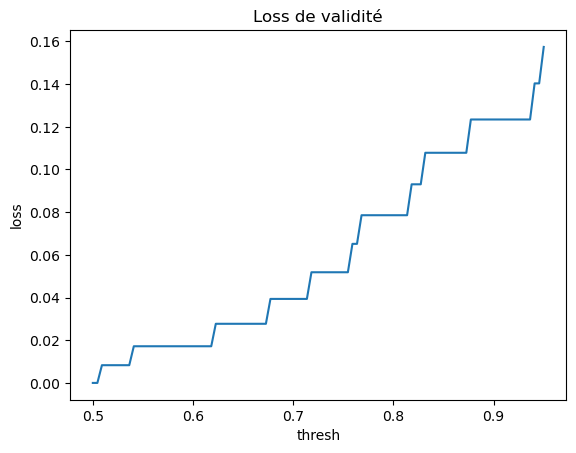

In [148]:
thresh = np.linspace(start=0.5, stop=0.95, num=100)
loss = [compute_loss_validity(cfs, query_instances, clf, thresh=t) for t in thresh]
plt.plot(thresh, loss)
plt.xlabel("thresh")
plt.ylabel("loss")
plt.title("Loss de validité")
plt.show()

Nous remarquons que la loss de validité devient plus importante à mesure que le seuil augmente. En effet, avec un seuil important, les exemples ont une grande probabilité être classifiés comme la classe non-souhaitée.

#### 6.3 Proximité des exemples contrefactuels à la requête

Nous pouvons voir que dans certains cas, les exemples contrefactuels générés sont très différentes de l'exemple à expliquer. Nous voulons que les exmples contrefactuels soit plus proche possible de l'exemple à expliquer.

Nous proposons:

$$
\text{proximité}(e, Y_C) = \frac{\sum_{i=1}^{n} [\min{(dist(e_i, Y_C))} < t]}{n}, \quad i \in \{1,\dots,n\}
$$

Où:
- $n$ est le nombre d'exemples contrefactuels
- $Y_C$ est l'ensemble de points qui appartiennent à la classe $C$
- $e_i$ est le i-ème exemple contrefactuel dans l'ensemble $e$
- $t$ est un seuil imposé à ne pas dépasser

Ce calcul permet de savoir quel est la proportion d'exemples contrefactuels qui sont assez proches de notre ensemble de la classe cible.

*Note*: on utilise la [notation Iverson](https://en.wikipedia.org/wiki/Iverson_bracket) pour la description de la formule, donc $[\min{(dist(e_i, Y_C))} < t]$ vaut 1 si la condition est vraie, 0 sinon.

In [149]:
def compute_loss_proximite_custom(cf_points, desired_dataset, thresh=0.05):
    points_within_threshold = 0
    for cf_point in cf_points:
        dists = np.linalg.norm(desired_dataset-cf_point, axis=1)
        min_distance_index = np.argmin(dists)
        if dists[min_distance_index] < thresh:
            points_within_threshold += 1
    return points_within_threshold / len(cf_points)

On cherche tous les points qui appartiennent à la classe 1.0. On peut alors les comparer aux points générés par DiCE pour voir s'ils sont acceptables.

In [150]:
# cinquième exemple: cfs5 généré
compute_loss_proximite_custom(cfs5_np, hm_df.query("target == 1.0")[['x', 'y']].to_numpy())

0.0

Revenons au premier exemple. Nous pouvons constater que la validité des exemples contrefactuels est meilleure, puisque la proportion d'exemples contrefactuels qui ne dépassent pas le seuil en distance est de 50%.

In [151]:
# Premier exemple: cfs généré
compute_loss_proximite_custom(cfs_np, hm_df.query("target == 1.0")[['x', 'y']].to_numpy())

0.56

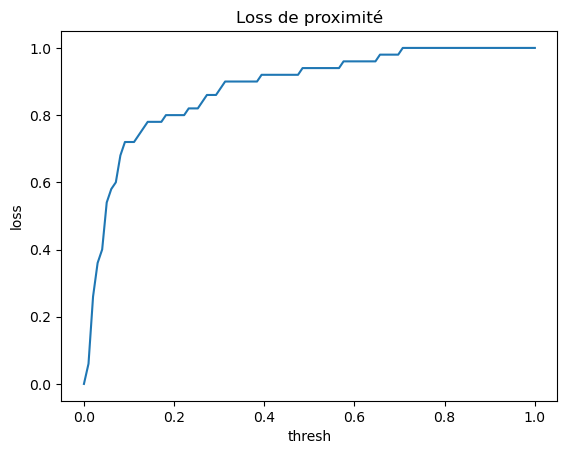

In [152]:
thresh = np.linspace(start=0, stop=1, num=100)
loss = [compute_loss_proximite_custom(cfs, hm_df.query("target == 1.0")[['x', 'y']].to_numpy(), thresh=t) for t in thresh]
plt.plot(thresh, loss)
plt.xlabel("thresh")
plt.ylabel("loss")
plt.title("Loss de proximité")
plt.show()

Nous allons créer ensuite la fonction loss pour la proximié en calculant la distance entre les exemples contrefactuels et l'exemple à expliquer
$$
\text{proximité}(e, x) = \frac{\sum_{i=1}^{k} dist(e_i, x)}{n}, \quad i \in \{1,\dots,n\}
$$

In [153]:
def compute_loss_proximite_2(cfs, query_instances, dataFrame):
    stds = dataFrame.std()
    dist = 0
    for i in range(len(cfs)):
        cf = cfs[i]
        for att in range(len(cf)):
            dist += abs(cf[att]-query_instances[att])/stds[att]
    return dist

In [162]:
compute_loss_proximite_2(cfs_np, query_instances.to_numpy()[0], dataFrame=hm_df)

68.17433401452882

Nous remarquons que plus des exemples contrefactuels sont proches des exemples souhaités, autrement dit, plus la distance entre eux et l'exemple à expliquer est grande, la loss est plus importante.

#### 6.4 Parcimonie des exemples contrefactuels

Nous proposons la suivante méthode d'analyse numérique pour la parcimonie, inspirée de la validité définie dans la section précédente.

$$
\text{parsimony}(x, e) = \sum_{i=1}^{n_x} |x_i - e_i|
$$

In [53]:
def compute_parsimony(x_point, cf_points, feats):
    #TODO not done
    parsimony = 0
    for cf_point in cf_points:
        for feat in feats:
            parsimony += np.abs(x_point[feat] - cf_point[feat])
    return parsimony

#### 6.5 Données classiques

Nous analyserons les données classiques du dataset de vins.

In [432]:
data_wine_path = 'data/winequality-red.csv'
df_wine = pd.read_csv(data_wine_path)

In [433]:
df_wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Nous allons observer le comportement d'un classifieur de la qualité des vins. Nous définissons un vin qui est "de qualité" quand son score de "quality" est supérieur ou égal à 7.

In [434]:
df_wine['quality'] = np.where(df_wine['quality'] >= 7, 1, 0)

In [435]:
def prepare_X(df):
    return df.values

In [436]:
from sklearn.ensemble import RandomForestClassifier

In [437]:
df_train, df_test = train_test_split(df_wine, test_size=0.2, random_state=1)

y_train = df_train.quality.values
y_test = df_test.quality.values

del df_train['quality']
del df_test['quality']

x_train = prepare_X(df_train)
x_test = prepare_X(df_test)

In [438]:
cols = list(df_wine.columns)
cols.pop() # on enlève quality
cols

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [439]:
X_train, X_test, y_train, y_test = train_test_split(df_wine[cols], df_wine['quality'], test_size=0.2, shuffle = True)
clf_wine = RandomForestClassifier(n_estimators=50, random_state=24)
clf_wine.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=24)

In [440]:
accuracy_score(y_test, clf_wine.predict(x_test))

0.778125

Nous pouvons maintenant créer un nouveau objet df_dice qui contient tous les attributs de la classe sauf celui à prédire: `quality`.

In [173]:
df_dice = dice_ml.Data(dataframe=df_wine, continuous_features=cols, outcome_name='quality')

In [174]:
model = dice_ml.Model(model=clf_wine, backend="sklearn")

In [175]:
explainer = dice_ml.Dice(df_dice, model, method='random')

In [176]:
query_instances = df_wine.drop(columns="quality")[0:1]
df_wine[0:1]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


La donnée `df_wine[0:1]` est un vin qui n'est pas de qualité selon nos critères. Les contrefactuels générés sont alors pour la classe `quality == 1`.

In [177]:
cfs_wine, cfs_wine_np = gen_cfs(explainer, query_instances, target='quality', n_counterfactuals=100)

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

Only 88 (required 100)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


In [178]:
compute_loss_validity(cfs_wine_np, query_instances.to_numpy(), clf=clf_wine,  thresh=0.7)

0.3602272727272728

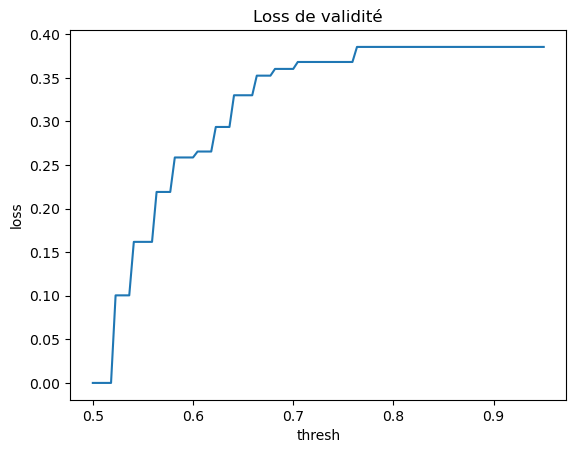

In [179]:
thresh = np.linspace(start=0.5, stop=0.95, num=100)
loss = [compute_loss_validity(cfs_wine_np, query_instances.to_numpy(), clf=clf_wine,  thresh=t) for t in thresh]
plt.plot(thresh, loss)
plt.xlabel("thresh")
plt.ylabel("loss")
plt.title("Loss de validité")
plt.show()

In [180]:
compute_loss_proximite_2(cfs_wine_np, query_instances.to_numpy()[0], dataFrame=df_wine)

1911.183475286776

#### 7. Variant de GS

Notre idée est: quand l'algorithme GS choisi la cible idéal, nous vérifions que la valeur de l'attribut indiqué ne dépasse pas un rayon de valeurs donné.

$
\quad \quad \quad \text{Pour attribut i,} \; | e_i-x_i | <= range
$

In [181]:
def generate_SL(x, ray1, ray2, n):
  d = x.shape[0]
  z = np.random.multivariate_normal(np.zeros(d),np.diag(np.ones(d)),n)
  z = (z/(np.linalg.norm(z, axis=1)).reshape((-1,1)))
  u = np.random.uniform(ray1**d, ray2**d, n)
  u = u**(1/d)
  u = u.reshape((-1,1))
  x_new = x+z*u
  return x_new

In [457]:
def GSG_modif(clf, x, etha, n, att, range):
  """
    Params:
      clf : le classifieur
      x   : la données à expliquer
      etha: hyperparametre, le rayon de recherche de l'algo
      n   : hyperparametre, le nombre de données générées à chaque itération de l'algo
      att : attribut à vérifier
      range: le seuil à ne pas dépasser
  """
  f_x = clf.predict([x])[0]
  z = generate_SL(x,0,etha,n)
  while (clf.predict(z)==f_x).sum()!=n:
    etha /=2
    z = generate_SL(x,0,etha,n)
  a0 = etha
  a1 = 2*etha

  e_cible = None
  while (clf.predict(z)==f_x).sum()==n:
    z = generate_SL(x,a0,a1,n)
    a0 = a1
    a1 += etha
    e = z[clf.predict(z)!=f_x]
    e = [a for a in e if abs(a[att]-x[att])<range]
    if e != [] :
      idx_min = np.argmin(np.linalg.norm(x-e, axis=1))
      e_cible = e[idx_min]
  # z = z[clf.predict(z)!=f_x]
  # idx_min = np.argmin(np.linalg.norm(x-z, axis=1))
  return e_cible

Ici, nous voulons que la valeur du premier attribut de l'exemple contre-factuel genéré s'éloigne au plus 1 unité de la valeur du premier attribut de l'exemple à expliquer:

In [468]:
att = 0
range = 1
x = X_train.to_numpy()[0]
e = GSG_modif(clf_wine, x, etha=10, n=30, att=att, range=range)

In [472]:
print(clf_wine.predict([x]))
pd.DataFrame(x).T

[0]


,0,1,2,3,4,5,6,7,8,9,10
0,9.9,0.57,0.25,2.0,0.104,12.0,89.0,0.9963,3.04,0.9,10.1


In [473]:
print(clf_wine.predict([e]))
pd.DataFrame(e).T

[1]


,0,1,2,3,4,5,6,7,8,9,10
0,9.907151,0.207671,0.243654,1.899989,-0.093815,12.177643,88.988067,1.103802,2.85323,1.213051,10.187468


### Conclusions

#### GSG

Nous pouvons observer une différence inférieure à 1 unité pour l'attribut 0 entre l'exemple choisi et son exemple contrefactuel. 

Ceci est très utile car il nous permet de maintenir nos explications pour l'appel à l'action dans les possibilités de l'usager, et maintenir les changements de manière parcimonieuse.

#### Validité et proximité

Pour obtenir un résultat similaire aux half moons, il est nécessaire de ne pas trop augmenter le seuil `thresh` dans l'appel à la fonction `compute_loss_validity`. Il semble que la génération d'exemples contrefactuels qui sont valides dépend aussi de la dimensionalité du problème. Nous pouvons conclure que la méthode DiCE a quelques limitations en termes de la validité des exemples qui sont générés, puisque nous pouvons obtenir des résultats divers en changeant quelques paramètres de dice_ml.